# DLToolboxImg: Part 3

# Table of Contents
- [Define File Iterator](#fileiter)
- [Define Evaluation Metric](#metric)
- [Define Model Architecture](#arch)
- [Select Learning Rate](#lrfind)
- [Select Initial weights](#weights)
- [Train Model](#train)
- [Save Model](#save)
- [Evaluate Model](#eval)
- [Modify Learnig Parameters](#train2)
- [Resume Training](#resume)
- [Compare Models](#compare)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.insert(0,"./src")

In [66]:
import mynnet7 as nn

## Define File Iterator

In [53]:
import mxnet as mx
import sys, os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
import pandas as pd
import re
from mxnet.io import DataIter
from mxnet.io import DataBatch
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from collections import namedtuple
import pickle

Batch = namedtuple('Batch', ['data'])

BATCH_SIZE,INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x = 8,32,32,32
def print_inferred_shape(net):
    ar, ou, au = net.infer_shape(data=(BATCH_SIZE, 1, INPUT_SIZE_z,INPUT_SIZE_y, INPUT_SIZE_x))
    print(net.name,ou)
class FileIter(DataIter):
    def __init__(self, path,
                 data_name="data",
                 label_name="softmax_label",
                 batch_size=8,
                 do_augment=False,
                 mean_image=.2815):

        
        self.epoch = 0
        self.mean_image = mean_image
        
        super(FileIter, self).__init__()
        self.batch_size = batch_size
        self.do_augment=do_augment


        #self.mean = cv2.imread(mean_image, cv2.IMREAD_GRAYSCALE)

        self.data_name = data_name
        self.label_name = label_name

        self.record = mx.recordio.MXRecordIO(path, 'r')

        
        def readrecord(record):
            record.reset()
            num_data=0
            while True:
                item = record.read()
                num_data+=1
                if not item:
                    break
            return num_data-1
        
        
        self.num_data = readrecord(self.record)#len(open(self.flist_name, 'r').readlines())
        
        self.cursor = -1
        self.record.reset()

        self.data, self.label = self._read()
        self.reset()

    def _read(self):
        """get two list, each list contains two elements: name and nd.array value"""
                
        data = {}
        label = {}

        dd = []
        ll = []
        for i in range(0, self.batch_size):
            
            item = self.record.read()            
            header, l = mx.recordio.unpack_img(item)
            
            d=header.label

            d=d.reshape((32,32,32))- self.mean_image
            d = np.expand_dims(d, axis=0) 
            d = np.expand_dims(d, axis=0)
            

            l=l.reshape((32*32*32))
            l = np.expand_dims(l, axis=0)
            l=l.astype(float)

            dd.append(d)
            ll.append(l)

        d = np.vstack(dd)
        l = np.vstack(ll)
        data[self.data_name] = d
        label[self.label_name] = l
        res = list(data.items()), list(label.items())
        return res

    @property
    def provide_data(self):
        """The name and shape of data provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.data]
        # print "data : " + str(res)
        return res

    @property
    def provide_label(self):
        """The name and shape of label provided by this iterator"""
        res = [(k, tuple(list(v.shape[0:]))) for k, v in self.label]
        return res
    

    def reset(self):
        self.cursor = -1
        self.record.reset()
        self.epoch += 1

    def getpad(self):
        return 0

    def iter_next(self):
        self.cursor += self.batch_size
        if self.cursor < self.num_data:
            return True
        else:
            return False

    def eof(self):
        res = self.cursor >= self.num_data
        return res

    def next(self):
        """return one dict which contains "data" and "label" """
        if self.iter_next():
            self.data, self.label = self._read()
 
            res = DataBatch(data=[mx.nd.array(self.data[0][1])], label=[mx.nd.array(self.label[0][1])], pad=self.getpad(), index=None)

            return res
        else:
            raise StopIteration



In [54]:
interm_dir4='/home/mas/x110/data'
train_data_path=interm_dir4+'/Train6Oct2018augment.rec'
BATCH_SIZE=1
train_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=True)

{'softmax_label': (1, 32768), 'data': (1, 1, 32, 32, 32)}


In [55]:
train_iter.reset()

In [56]:
batch = train_iter.next()
X =  batch.data[0][0][0].asnumpy()
Y = batch.label[0].reshape((32,32,32)).asnumpy()

In [57]:
X.shape,Y.shape

((32, 32, 32), (32, 32, 32))

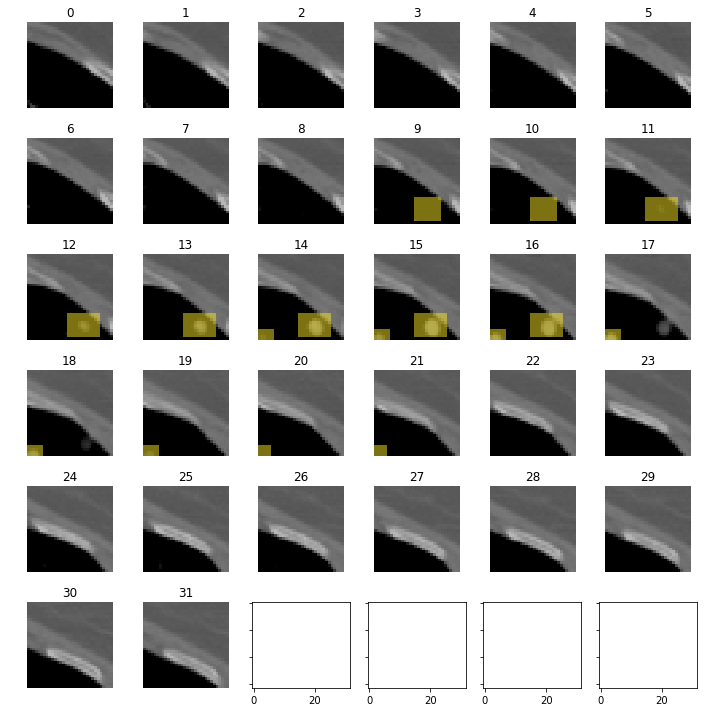

In [58]:
zs=32

X2,Z2 = X,Y
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=6
num_cols=6

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(10,10))

ind=np.arange(0,32)
for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(X2[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.5,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title(str(ii))
      
plt.tight_layout()

## Find mean of images

In [59]:
interm_dir4='/home/mas/x110/data'
train_data_path=interm_dir4+'/Train6Oct2018augment.rec'
BATCH_SIZE=1
train_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0)
train_iter.reset()
x_mean = np.zeros((32,32,32))
for i,batch in enumerate(train_iter):
    X =  batch.data[0][0][0].asnumpy()
    x_mean+=X
x_mean=np.mean(x_mean/i)
x_mean#x_mean=.2815

0.2815327279660965

In [62]:
BATCH_SIZE=1
train_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

In [80]:
BATCH_SIZE=1
valid_iter=FileIter(train_data_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean)

In [81]:
train_iter.reset()
valid_iter.reset()

In [77]:
## Optimizer

In [78]:
# ===============Optimizer=================                        
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.0001,momentum=0.99,wd=0.000001)
    
updater = mx.optimizer.get_updater(opt)

In [67]:
# ===============Evaluation metric(s)================= 
metric = mx.metric.CustomMetric(feval=nn.dice_coef2)

## Define Model Architecture

In [69]:
network = nn.get_net_315()
init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

In [70]:
# Binding
exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)
# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]

In [71]:
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)

/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
!mkdir /home/mas/x110/model

mkdir: cannot create directory ‘/home/mas/x110/model’: File exists


In [76]:
prefix = "/home/mas/x110/model/oct08"

In [ ]:
### import time

for epoch in range(100):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 50== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 4.56404709815979 Epoch: 0 trainloss: -0.120204486 validloss: -0.11542028
